# Tutorial \#4: Coverage Prediction using Geo2SigMap's ML Model and Comparison with Measurement Data

This tutorial demonstrates the complete workflow for:
1. **Scene Generation**: Creating 2D building maps for specified PCI locations;
2. **Data Preparation**: Processing real-world measurement data;
3. **Model Inference**:
  - 1st U-Net: Isotropic antenna pattern prediction;
  - 2nd U-Net: Fine-grained prediction with sparse measurements;
4. **Performance Evaluation**: Quantitative comparison with ground truth (field measurements).

**Technical Specifications**:
- Area size: 512m x 512m;
- Spatial resolution: 4m x 4m (per pixel);
- Model input/output dimension: 128 × 128 (pixel x pixel)

**Prerequisites**:
- Please make sure that **PyTorch** is installed: check the [PyTorch website](https://pytorch.org/get-started/locally/) for more info.;
- Download the pre-trained model weights for Geo2SigMap's deep learning (DL) model and save them to `data/model_unet/`.

In [2]:
import torch

from sklearn.metrics import mean_squared_error, mean_absolute_error,root_mean_squared_error

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import math
import random

from scene_generation.core import Scene
from scene_generation.utils import rect_from_point_and_size, get_utm_epsg_code_from_gps, gps_to_utm_xy, get_center_subarray
from scene_generation.empirical_pathloss_model import pathloss_38901
from scene_generation.unet.unet_model_rt import UNet

## Experimental Setup

**Configuration**:
- Target PCI: A
- Measurement device: Samsung
- Number of sparse measurement samples input to the DL model: 200

Make sure you download the pre-trained model weights from our github repo's release page and put them under `data/ml` folder.

For detailed information about the measurement device and PCI, refer to our [paper](https://arxiv.org/pdf/2312.14303).

In [4]:
mea_device = "Samsung"
which_PCI = "A"
SS_NUM = 200
RESOLUTION = 4

scene_dir = "../scenes/Duke_{}".format(which_PCI)

state_dict_1st_UNet = "../data/model_unet/1st_checkpoint_epoch58.pth"
state_dict_2nd_UNet = "../data/model_unet/2nd_checkpoint_epoch110.pth"

cell_info_dict = {
    'PCI':['A', 'B', 'C', 'D','E', 'F' ],
    'center_lat_lon':[
        (35.999186254897836, -78.9397858960648),
        (35.999186254897836, -78.9397858960648),
        (35.999186254897836, -78.9397858960648),
        (35.999186254897836, -78.9397858960648),
        (36.00307128210248, -78.93706070613855),
        (36.00307128210248, -78.93706070613855)
    ],
    'top-left_lat_lon':[
        (36.001483241320656, -78.94273733701348),
        (36.001483241320656, -78.94273733701348),
        (36.001483241320656, -78.94273733701348),
        (36.001483241320656, -78.94273733701348),
        (36.005429554748495, -78.93998431793196), 
        (36.005429554748495, -78.93998431793196), 
    ],
    'azimuth':[212, 212, 30, 30, 216, 216 ],
    'freq':[3.69e9, 3.64e9, 3.58e9, 3.56e9, 3.69e9, 3.64e9 ]
}

cell_info_df = pd.DataFrame(cell_info_dict)

## 1. Scene Generation

Different from the CLI tools `scenegen`, here we will directly use the Python function API to generate the scene. The Python function provides more flexibility than the CLI tool for advanced use cases.


In [5]:
polygon_points_gps = rect_from_point_and_size(
    cell_info_df[cell_info_df["PCI"] == which_PCI]['top-left_lat_lon'][0][1],
    cell_info_df[cell_info_df["PCI"] == which_PCI]['top-left_lat_lon'][0][0],
    "top-left", 
    512,
    512
)
min_lon, min_lat = polygon_points_gps[0]
max_lon, max_lat = polygon_points_gps[2]
print(
    f"Check the bbox at http://bboxfinder.com/#{min_lat:.{4}f},{min_lon:.{4}f},{max_lat:.{4}f},{max_lon:.{4}f}"
)

scene_instance = Scene()
scene_instance(
    polygon_points_gps,
    scene_dir,
    None,
    osm_server_addr="https://overpass-api.de/api/interpreter",
    lidar_calibration=False,
    generate_building_map=True
)

utm_epsg = get_utm_epsg_code_from_gps(
    cell_info_df[cell_info_df["PCI"] == which_PCI]['top-left_lat_lon'][0][1],
    cell_info_df[cell_info_df["PCI"] == which_PCI]['top-left_lat_lon'][0][0],
)

Check the bbox at http://bboxfinder.com/#35.9969,-78.9429,36.0014,-78.9371


Parsing buildings: 100%|█████████████████████████████████████████████| 57/57 [00:00<00:00, 269.77it/s]


In [6]:
from sionna.rt import load_scene

# Load scene and access Mitsuba's internal representation
scene = load_scene("../scenes/Duke_A/scene.xml")

# Interative 3D visualization and view of the scene
scene.preview()

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

Original Building Map Shape: (512, 512)
Cropped Building Map Shape:  (512, 512)


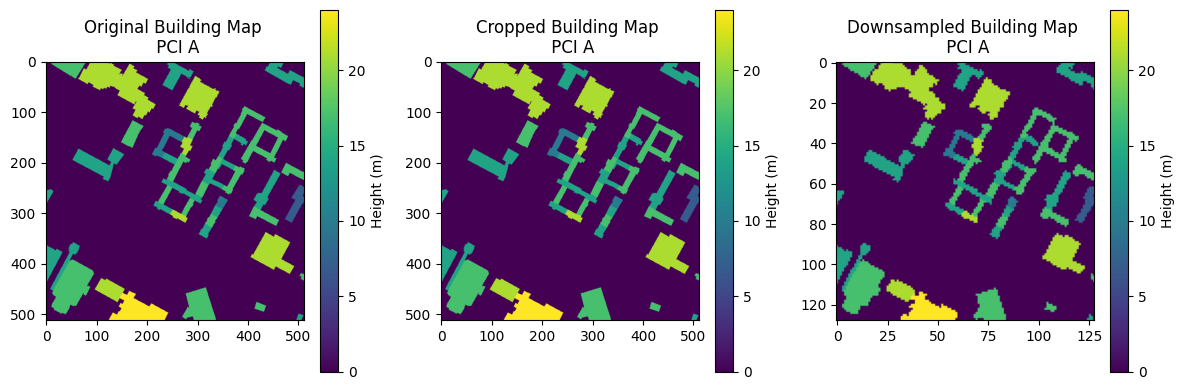

In [8]:
building_map_npy_ori = np.load("{}/2D_Building_Height_Map.npy".format(scene_dir))

print("Original Building Map Shape:", building_map_npy_ori.shape)
building_map_npy = get_center_subarray(building_map_npy_ori, 512, 512)
print("Cropped Building Map Shape: ", building_map_npy.shape)

building_map_npy_res_4 = building_map_npy[::4,::4]

# Create side-by-side plots for original, cropped, down-sampled building map
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

# 1) Original building map
im_ori_bmap = axes[0].imshow(building_map_npy_ori)
axes[0].set_title('Original Building Map \n PCI {}'.format(which_PCI))
cbar_raw = plt.colorbar(im_ori_bmap, ax=axes[0])
cbar_raw.set_label('Height (m)')

# 2) Cropped building map (center 512x512 subarray)
im_cropped_bmap = axes[1].imshow(building_map_npy)
axes[1].set_title('Cropped Building Map \n PCI {}'.format(which_PCI))
cbar_db = plt.colorbar(im_cropped_bmap, ax=axes[1])
cbar_db.set_label('Height (m)')

# 3) Down sampled building map
im_ds_bmap = axes[2].imshow(building_map_npy_res_4)
axes[2].set_title('Downsampled Building Map \n PCI {}'.format(which_PCI))
cbar_db_flip = plt.colorbar(im_ds_bmap, ax=axes[2])
cbar_db_flip.set_label('Height (m)')

plt.tight_layout()
plt.show()

## 2. Measurement Data Preparation


**Note:** Check tutorial `3_visualize_measurements.ipynb` for better visualization of measurement data.

In [9]:
measurement_data = pd.read_csv("../data/measurements/Duke_CBRS.csv")

# Filter out the measurement data collected by a specified device and/or PCI
measurement_data_filtered = measurement_data[(measurement_data['PCI'] == which_PCI) & (measurement_data['device'] == mea_device)]

measurement_data_filtered

,PCI,latitude,longitude,device,rsrp
203,A,35.998821,-78.940651,Samsung,-80
571,A,35.999005,-78.940536,Samsung,-88
573,A,35.998797,-78.940672,Samsung,-81
598,A,35.999466,-78.940202,Samsung,-110
600,A,35.998288,-78.939732,Samsung,-88
...,...,...,...,...,...
20348,A,35.999540,-78.940308,Samsung,-103
20349,A,35.998634,-78.943191,Samsung,-115
20351,A,35.995545,-78.943101,Samsung,-103
20352,A,35.995504,-78.939662,Samsung,-110


Total number of measurements:  1850
Total # of pixels after rasterization to 4m resolution: 550
Total # of valid pixels (no overlapping with buildings):  530


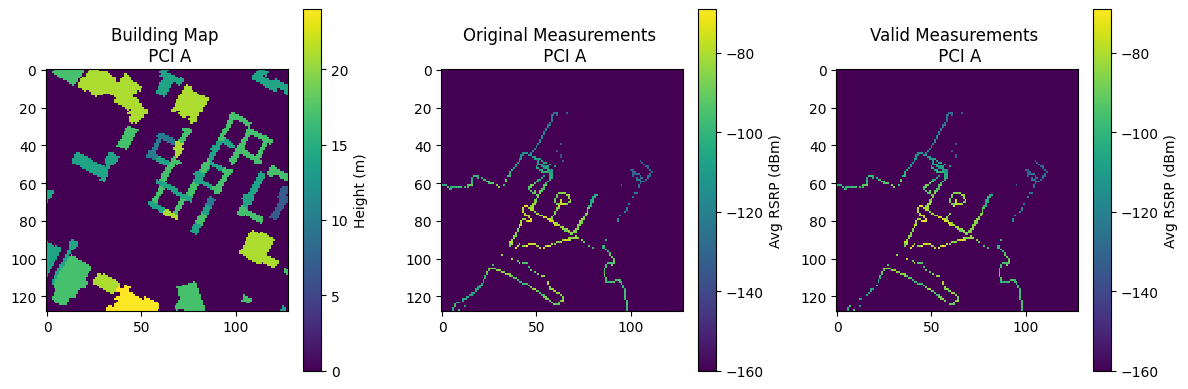

In [10]:
# Generate a list of tuples (numpy_row, numpy_col, rsrp) by converting the (lat, lon) into local coordinates
measurement = np.empty([len(measurement_data_filtered["latitude"]), 3])
measurement[:, 0] = measurement_data_filtered["latitude"]
measurement[:, 1] = measurement_data_filtered["longitude"]
measurement[:, 2] = measurement_data_filtered["rsrp"]

top_left_coord_x_utm,top_left_coord_y_utm, _   = gps_to_utm_xy(
    cell_info_df[cell_info_df["PCI"] == which_PCI]['top-left_lat_lon'][0][1],
    cell_info_df[cell_info_df["PCI"] == which_PCI]['top-left_lat_lon'][0][0],
    utm_epsg)

for idx, point in enumerate(measurement):
    mea_x_utm, mea_y_utm, _ = gps_to_utm_xy(measurement[idx,1], measurement[idx,0], utm_epsg)
    row = top_left_coord_y_utm - mea_y_utm 
    col =  mea_x_utm - top_left_coord_x_utm
    
    measurement[idx, 0] = row
    measurement[idx, 1] = col

ground_truth_list = measurement

print("Total number of measurements: ", len(ground_truth_list))

ground_truth_tmp = np.empty((128, 128), dtype=object)
count_num_no_building = 0

for point in ground_truth_list:
    row = int(point[0]/4)
    col = int(point[1]/4)
    if row >=128 or col >= 128 or row < 0 or col < 0:
        # print("{}:{}".format(row,col))
        continue
    if ground_truth_tmp[row, col] is None:
        ground_truth_tmp[row, col] = np.array(point[2])
    else:
        ground_truth_tmp[row][col] = np.append(ground_truth_tmp[row][col], point[2])

ground_truth_arr = np.empty((128, 128))
for row in range(128):
    for col in range(128):
        if ground_truth_tmp[row, col] is None:
            ground_truth_arr[row][col] = -160
        else:
            # ground_truth_arr[row][col] = ground_truth_tmp[row,col].mean()
            # ground_truth_arr[row][col] = np.median(ground_truth_tmp[row,col])
            ground_truth_arr[row][col] = 10 * np.log10( ( 10 ** ( ground_truth_tmp[row,col]/ 10)  ).mean() )

# Filter out the pixels blocked by the building (e.g., due to GPS and/or geographical data error)
condition = (ground_truth_arr != -160) & (building_map_npy_res_4 != 0)

ground_truth_arr_valid = ground_truth_arr.copy()
ground_truth_arr_valid[condition] = -160  # Update values

print("Total # of pixels after rasterization to 4m resolution: {}".format(np.sum(ground_truth_arr != -160))) 
print("Total # of valid pixels (no overlapping with buildings):  {}".format(np.sum(ground_truth_arr_valid != -160)))
  
# Create side-by-side plots for original, cropped, down-sampled building map
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

# 1) Building map
im_bmap = axes[0].imshow(building_map_npy_res_4, interpolation='none')
axes[0].set_title('Building Map \n PCI {}'.format(which_PCI))
cbar_raw = plt.colorbar(im_bmap, ax=axes[0])
cbar_raw.set_label('Height (m)')

# 2) TX positional map
im_ori_mea = axes[1].imshow(ground_truth_arr, interpolation='none')
axes[1].set_title('Original Measurements \n PCI {}'.format(which_PCI))
cbar_db = plt.colorbar(im_ori_mea, ax=axes[1])
cbar_db.set_label('Avg. RSRP (dBm)')

# 3) Pathloss
im_valid_mea = axes[2].imshow(ground_truth_arr_valid, interpolation='none')
axes[2].set_title('Valid Measurements \n PCI {}'.format(which_PCI))
cbar_db_flip = plt.colorbar(im_valid_mea, ax=axes[2])
cbar_db_flip.set_label('Avg. RSRP (dBm)')

plt.tight_layout()
plt.show()

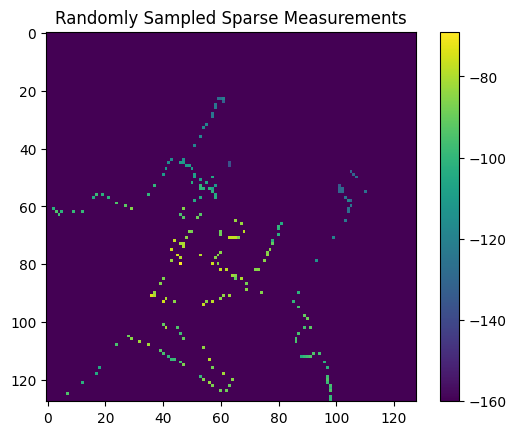

In [14]:
ss_map = np.full((128, 128), -160)

# Get valid positions (where ground_truth_arr_valid != -160)
valid_positions = np.argwhere(ground_truth_arr_valid != -160)  # Get (row, col) indices
    
# Randomly select SS_NUM positions from valid ones
# Note that the selected measurements vary from run to run if no seed is specified
selected_indices = valid_positions[np.random.choice(len(valid_positions), SS_NUM, replace=False)]

# Copy values from the original array to the ss_map at selected positions
for row, col in selected_indices:
    ss_map[row, col] = ground_truth_arr_valid[row, col]

plt.imshow(ss_map, interpolation='none')
plt.title("Randomly Sampled Sparse Measurements")
plt.colorbar()
plt.show()

## 3. **Model Inference**
- 1st U-Net: Isotropic antenna pattern prediction

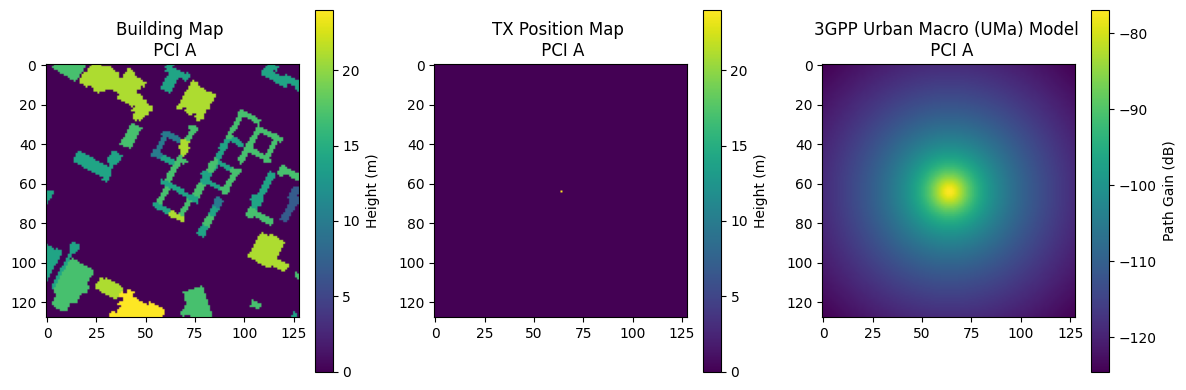

In [15]:
# Construct the TX position channel
tx_x = 256
tx_y = 256
tx_position = [tx_x // 4, tx_y // 4]
tx_height = 24
tx_position_channel = np.full((128, 128), 0, dtype=int)
# tx_height = np.max(building_height_arr)
tx_position_channel[tx_position[1]][tx_position[0]] = tx_height

distance = np.arange(0, 1450, 1)

# lookup table for path_loss_res, resolution=1 meter
path_loss_res, _ =  pathloss_38901(distance,3.64, h_bs=int(tx_height), h_ut=2)

path_loss_heat_map = np.full((128, 128), 0, dtype=float)

for row in range(path_loss_heat_map.shape[0]):
    for col in range(path_loss_heat_map.shape[1]):
        # Compute the distance between pixel and tx
        dist = math.sqrt((tx_position[1]*4 - row*4)**2 + (tx_position[0]*4 - col*4)**2) 
        path_loss_heat_map[row][col] =  -1 * path_loss_res[int(dist)]

net_iso = UNet(n_channels=2, n_classes=1, bilinear=False, pathloss=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net_iso.to(device=device)

# Load the state dict
state_dict = torch.load(state_dict_1st_UNet, map_location=device)
net_iso.load_state_dict(state_dict)

# Combine all the channels together
combined_input = np.zeros((3, 128, 128), dtype=float)
combined_input[0,:, :] = np.copy(building_map_npy_res_4)
combined_input[1,:, :] = tx_position_channel
combined_input[2,:, :] = path_loss_heat_map

# Create side-by-side plots for original, cropped, down-sampled building map
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

# 1) Building map
im_bmap = axes[0].imshow(combined_input[0,:, :])
axes[0].set_title('Building Map \n PCI {}'.format(which_PCI))
cbar_raw = plt.colorbar(im_bmap, ax=axes[0])
cbar_raw.set_label('Height (m)')

# 2) TX positional map
im_tx_pos = axes[1].imshow(combined_input[1,:, :])
axes[1].set_title('TX Position Map \n PCI {}'.format(which_PCI))
cbar_db = plt.colorbar(im_tx_pos, ax=axes[1])
cbar_db.set_label('Height (m)')

# 3) Pathloss
im_uma = axes[2].imshow(combined_input[2,:, :])
axes[2].set_title('3GPP Urban Macro (UMa) Model \n PCI {}'.format(which_PCI))
cbar_db_flip = plt.colorbar(im_uma, ax=axes[2])
cbar_db_flip.set_label('Path Gain (dB)')

plt.tight_layout()
plt.show()

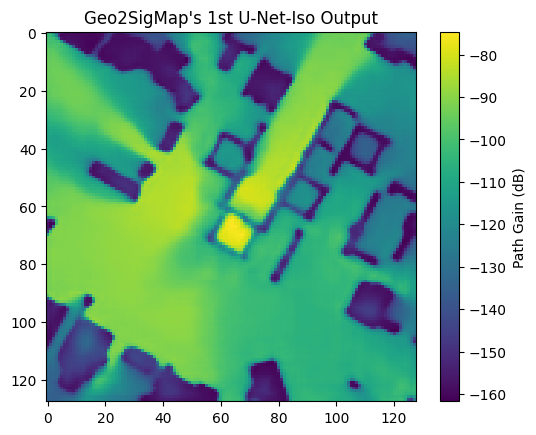

In [19]:
# Eval
images =  torch.as_tensor(combined_input.copy()).float().contiguous()

# Since we load the data manually, add batch dimension to the front of the data
images = images[None,:, :, :]

net_iso.eval()

images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)

with torch.no_grad():
    output = net_iso(images).squeeze().cpu()

output_iso_UNet = output.squeeze().cpu().numpy()

plt.imshow(output_iso_UNet, interpolation='none')
plt.title("Geo2SigMap's 1st U-Net-Iso Output")
cbar_db = plt.colorbar()
cbar_db.set_label('Path Gain (dB)')
plt.show()

## 3. **Model Inference**
- 2nd U-Net: Fine-grained prediction with sparse measurements

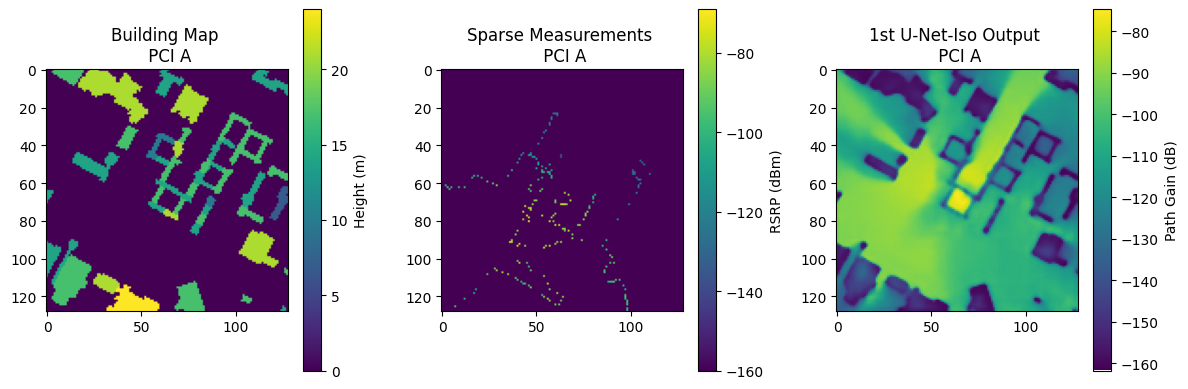

In [23]:
# 1. Create the model
net = UNet(n_channels=3, n_classes=1, bilinear=False, pathloss=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device=device)

# 2. Load the state dict
state_dict = torch.load(state_dict_2nd_UNet, map_location=device)
net.load_state_dict(state_dict)

combined_input = np.zeros((3, 128, 128), dtype=float)

# Combine all the channels together
combined_input[0,:, :] = building_map_npy_res_4
combined_input[1,:, :] = ss_map
combined_input[2,:, :] = output_iso_UNet

# Create side-by-side plots for original, cropped, down-sampled building map
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

# 1) Building map
im_bmap = axes[0].imshow(combined_input[0,:,:])
axes[0].set_title('Building Map \n PCI {}'.format(which_PCI))
cbar_raw = plt.colorbar(im_bmap, ax=axes[0])
cbar_raw.set_label('Height (m)')

# 2) Sparse Measurements
im_ss = axes[1].imshow(combined_input[1,:,:])
axes[1].set_title('Sparse Measurements \n PCI {}'.format(which_PCI))
cbar_db = plt.colorbar(im_ss, ax=axes[1])
cbar_db.set_label('RSRP (dBm)')

# 3) 1st U-Net output
im_1st_output = axes[2].imshow(combined_input[2,:,:])
axes[2].set_title('1st U-Net-Iso Output \n PCI {}'.format(which_PCI))
cbar_db_flip = plt.colorbar(im_1st_output, ax=axes[2])
cbar_db_flip.set_label('Path Gain (dB)')

plt.tight_layout()
plt.show()


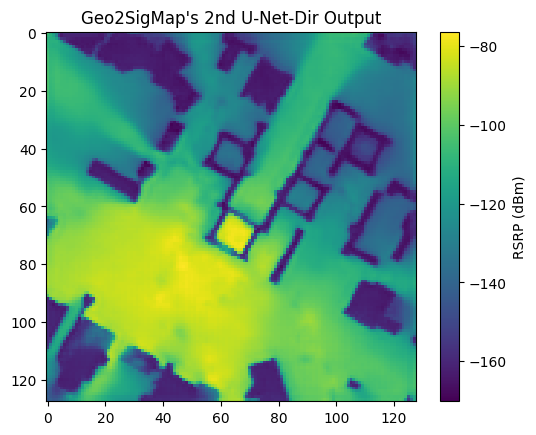

In [25]:
# 4. Eval
images = torch.as_tensor(combined_input.copy()).float().contiguous()

# Since we directly load the data manually, add batch dimension to the front of data
images = images[None,:, :, :]

net.eval()

images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)

with torch.no_grad():
    output = net(images).cpu()
output = output.squeeze().cpu().numpy()

plt.imshow(output, interpolation='none')
plt.title("Geo2SigMap's 2nd U-Net-Dir Output")
cbar_db = plt.colorbar()
cbar_db.set_label('RSRP (dBm)')
plt.show()

## 4. **Performance Evaluation**: Quantitative comparison with ground truth (Field measurements)


In [26]:
def evaluate_predictions(y_true, y_pred, model_name):
    """Calculate comprehensive evaluation metrics"""
    mask = y_true != -160  # Ignore invalid pixels
    
    metrics = {
        'RMSE (dB)': root_mean_squared_error(y_true[mask], y_pred[mask]),
        'MAE (dB)': mean_absolute_error(y_true[mask], y_pred[mask]),
    }
    
    print(f"\n{model_name} Performance:")
    for k, v in metrics.items():
        print(f"- {k}: {v:.2f}")
    
    return metrics

# Compare all predictions
metrics_iso = evaluate_predictions(ground_truth_arr_valid, output_iso_UNet, "1st U-Net (Isotropic)")
metrics_adaptive = evaluate_predictions(ground_truth_arr_valid, output, "2nd U-Net (Adaptive)")


1st U-Net (Isotropic) Performance:
- RMSE (dB): 15.05
- MAE (dB): 12.80

2nd U-Net (Adaptive) Performance:
- RMSE (dB): 5.41
- MAE (dB): 3.70
